Load V1 receptive fields from Ringach et. al. and compute covariance matrix

In [26]:
import numpy as np
import numpy.linalg as la
import glob
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from estimator import V1_inspired_weights, V1_inspired_weights_same_center
import h5py

In [27]:
dataroot = 'data/V1_data_Ringach/'
data = sio.loadmat(dataroot + 'rf_db.mat')['rf']
num_cells, dim = 250, 32 ** 2 # 250 cells with RF of size 32 x 32

In [28]:
# different cells have difference receptive field sizes (32 x 32, 64 x 64, 128 x 128). 
# Downsample them all to be 32 x 32.
STA = np.zeros((num_cells, dim))
time_to_peak = np.zeros(num_cells)
d2p = np.zeros(num_cells)

for cell in range(num_cells):
    s = data[0][cell][0]
    resize_factor = int(s.shape[0] / 32)
    s_scaled = downscale_local_mean(s, (resize_factor, resize_factor))
    STA[cell] = s_scaled.flatten()
    time_to_peak[cell] = data[0][cell][1]
    d2p[cell] = data[0][cell][2]

For both model and data, compute the covariance matrix along with the eigenvectors and eigenvalues

In [32]:
# pre-processing; z-score all the receptive fields
STA = (STA - np.mean(STA, axis=1).reshape(-1, 1)) / np.std(STA, axis=1).reshape(-1, 1)

# generate receptive field from our random feature model
W = V1_inspired_weights(num_cells, dim, t=2,l=1.5, scale=1, random_state=None)
W = (W - np.mean(W, axis=1).reshape(-1, 1)) / np.std(W, axis=1).reshape(-1, 1)

# covariance matrices
C_data = STA.T @ STA
C_data *= dim / np.trace(C_data).reshape(-1, 1)

C_model = W.T @ W
C_model *= dim / np.trace(C_model).reshape(-1, 1)

# spectra analyses
eigval_data, eigvec_data = la.eigh(C_data)
eigval_model, eigvec_model = la.eigh(C_model)

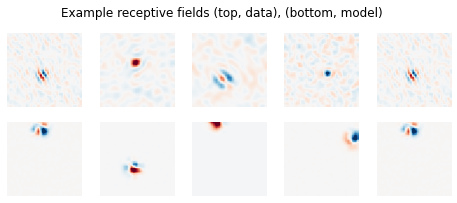

In [33]:
# plot a few receptive fields
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Example receptive fields (top, data), (bottom, model)', y=1)
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    idx = np.random.randint(num_cells)
    plt.imshow(STA[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)

    ax = fig.add_subplot(2, 5, 5 + i+1)
    plt.imshow(W[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)
# plt.savefig('results/ringach_data/receptive_fields.pdf')

Visualize the covariance matrices and plot the eigenalue spectrum

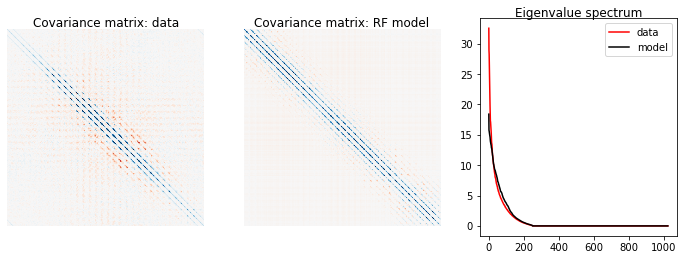

In [34]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data, cmap='RdBu')
plt.clim(-0.5, 0.5)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(132)
plt.title('Covariance matrix: RF model', y=0.98)
plt.imshow(C_model, cmap='RdBu')
plt.clim(-0.5, 0.5)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(133)
plt.title('Eigenvalue spectrum', y=0.98)
plt.plot(np.flip(eigval_data), '-r', label='data')
plt.plot(np.flip(eigval_model), '-k', label='model')
plt.legend()
# plt.savefig('results/ringach_data/covariance_matrices.pdf')

Plot the first significant eigenvectors

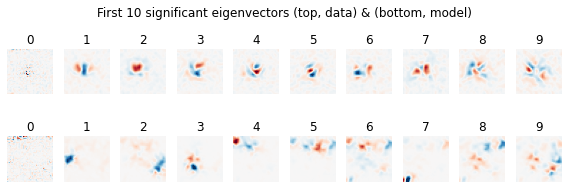

In [45]:
# plot the eigenvecs
fig = plt.figure(figsize=(8, 3))
plt.suptitle('First 10 significant eigenvectors (top, data) & (bottom, model)')
for i in range(10):
    ax = fig.add_subplot(2, 10, i+1)
    ax.set_title(i)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_data[:, -i].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
    
    ax = fig.add_subplot(2, 10, 10 + i +1)
    ax.set_title(i)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_model[:, -i].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.savefig('results/ringach_data/cov_matrix_eigvecs.pdf')

## Center all receptive fields

In [46]:
from scipy import ndimage

centered_STA = np.zeros_like(STA)
for i, img in enumerate(STA):
    img = img.reshape(32, 32)
    # calculate the center of mass
    center_of_mass = ndimage.measurements.center_of_mass(np.abs(img) ** 3)
    center_of_mass = np.round(center_of_mass).astype('int')
    
    # translate image but wrap around so that center of mass is shifted to center most pixel
    centered_img = np.roll(img, 16 - center_of_mass[0], axis=0)
    centered_img = np.roll(centered_img, 16 - center_of_mass[1], axis=1)
    
    centered_STA[i] = centered_img.flatten()

Mean com: [15.96976753 15.84888924] std com: [0.53187822 0.598786  ]


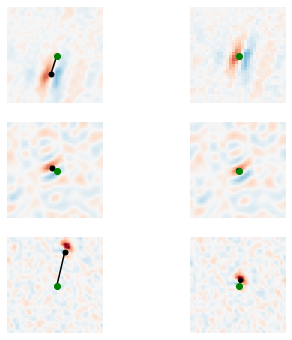

In [48]:
# plot to verify 
idx = np.random.randint(0, 250, 3) #164    

fig = plt.figure(figsize=(6, 6))
for i, j in enumerate(idx):
    ax = fig.add_subplot(3, 2, 2 * (i + 1) - 1)
    img = STA[j].reshape(32, 32)
    com = ndimage.measurements.center_of_mass(np.abs(img) ** 3)
    plt.imshow(img, cmap='RdBu')
    plt.plot([com[1], 16], [com[0], 16], 'k-o', markersize=5)
    plt.plot(16, 16, 'og')
    plt.clim(-10, 10)
    plt.axis('off')

    ax = fig.add_subplot(3, 2, 2 * (i + 1))
    img = centered_STA[j].reshape(32, 32)
    com = ndimage.measurements.center_of_mass(np.abs(img) ** 3)
    plt.imshow(img, cmap='RdBu')
    plt.plot([com[1], 16], [com[0], 16], 'ko', markersize=4)
    plt.plot(16, 16, 'og')
    plt.clim(-10, 10)
    plt.axis('off')
# plt.savefig('results/ringach_data/center_receptive_fields.pdf')

# print average center of mass of centered images
com_list = []
for img in centered_STA:
    img = img.reshape(32, 32)
    com = np.array(ndimage.measurements.center_of_mass(np.abs(img) ** 3))
    com_list.append(com)
com_list = np.array(com_list)
print('Mean com:', np.mean(com_list, axis=0), 'std com:', np.std(com_list, axis=0))

Generate covariance matrices from centered RFs

In [49]:
from estimator import V1_inspired_kernel_matrix
# covariance matrices
C_data = centered_STA.T @ centered_STA
C_data *= dim / np.trace(C_data).reshape(-1, 1)

# generate receptive field from our random feature model using finite number of cells
W = V1_inspired_weights_same_center(num_cells, dim, t=2,l=1.5, m=(16, 16), scale=1, random_state=22)
W = (W - np.mean(W, axis=1).reshape(-1, 1)) / np.std(W, axis=1).reshape(-1, 1)
C_model_finite_sample = W.T @ W
C_model_finite_sample *= dim / np.trace(C_model_finite_sample).reshape(-1, 1)

# full covariance function
C_model = V1_inspired_kernel_matrix(dim, t=2, l=1.5, m=(16, 16), scale=1)
C_model *= dim / np.trace(C_model).reshape(-1, 1)

# spectra analyses
eigval_data, eigvec_data = la.eigh(C_data)
eigval_model, eigvec_model = la.eigh(C_model)
eigval_model_finite_sample, eigvec_model_finite_sample = la.eigh(C_model_finite_sample)

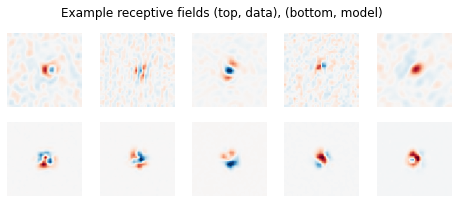

In [54]:
# plot a few receptive fields
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Example receptive fields (top, data), (bottom, model)', y=1)
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    idx = np.random.randint(num_cells)
    plt.imshow(centered_STA[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)
#     plt.colorbar()
    

    ax = fig.add_subplot(2, 5, 5 + i+1)
    plt.imshow(W[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    plt.clim(-10, 10)
#     plt.colorbar()
plt.savefig('results/ringach_data/receptive_fields_centered.pdf')

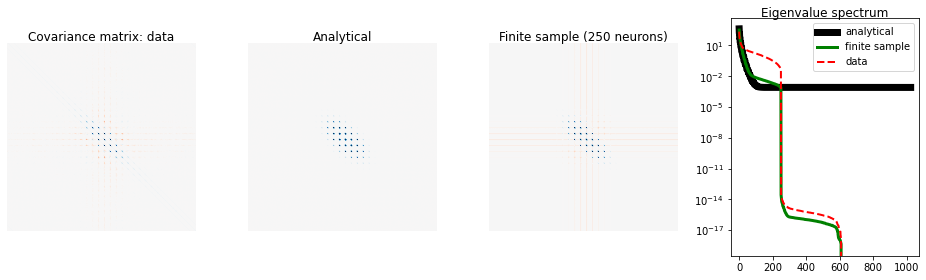

In [57]:
clim = 4
fig = plt.figure(figsize=(13, 4))
ax = fig.add_subplot(141)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data, cmap='RdBu')
plt.clim(-clim, clim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(142)
plt.title('Analytical', y=0.98)
plt.imshow(C_model, cmap='RdBu')
plt.clim(-clim, clim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(143)
plt.title('Finite sample (250 neurons)', y=0.98)
plt.imshow(C_model_finite_sample, cmap='RdBu')
plt.clim(-clim, clim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(144)
plt.title('Eigenvalue spectrum', y=0.98)
plt.semilogy(np.flip(eigval_model), 'k-', lw=7,label='analytical')
plt.semilogy(np.flip(eigval_model_finite_sample), '-g', lw=3,  label='finite sample')
plt.semilogy(np.flip(eigval_data), 'r--', lw=2, label='data')
plt.legend()
plt.tight_layout()
# plt.colorbar()
plt.savefig('results/ringach_data/covariance_matrices_centered_data.pdf')

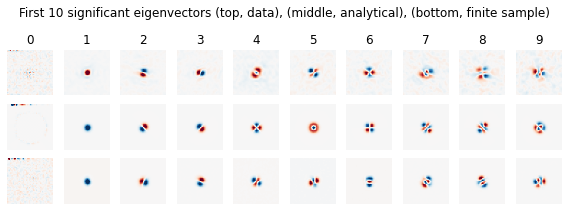

In [58]:
# plot the eigenvecs
fig = plt.figure(figsize=(8, 3))
plt.suptitle('First 10 significant eigenvectors (top, data), (middle, analytical), (bottom, finite sample)')
for i in range(10):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(i)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_data[:, -i].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 10 + i +1)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_model[:, -i].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 20 + i +1)
    idx = np.random.randint(num_cells)
    plt.imshow(eigvec_model_finite_sample[:, -i].reshape(32, 32), cmap='RdBu')
    plt.clim(-0.25, 0.25)
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.8)
# plt.savefig('results/ringach_data/cov_matrix_eigvecs_centered_data.pdf')